# Data Visualization

This Jupyter notebook has all visualizations. Users can interact with the graphs without installing dependencies.

In [ ]:
# Upgrade pip
pip install --upgrade pip  

# Install required libraries
pip install numpy pandas seaborn numpy plotly

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import plotly.subplots as sp

In [12]:
# Load the dataset
file_path = "./data 1.csv"  # Update this path if needed
df = pd.read_csv(file_path)

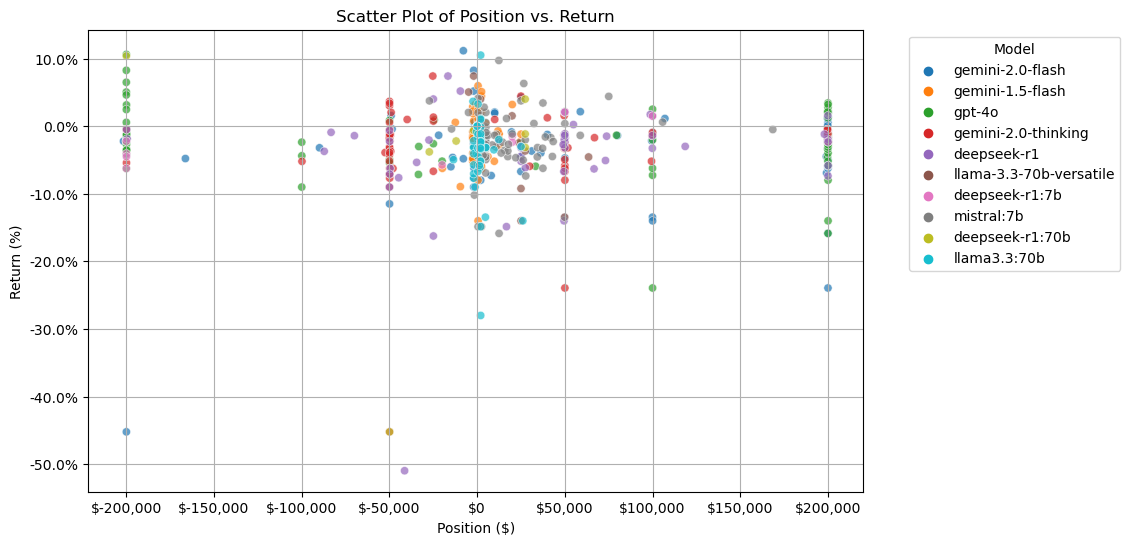

In [9]:
plt.figure(figsize=(10, 6))
ax = sns.scatterplot(x=df["position"], y=df["return"], hue=df["model"], alpha=0.7)

# Format x-axis as dollars
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.0f}'))

# Format y-axis as percentages
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.1%}'))

plt.xlabel("Position ($)")
plt.ylabel("Return (%)")
plt.title("Scatter Plot of Position vs. Return")
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

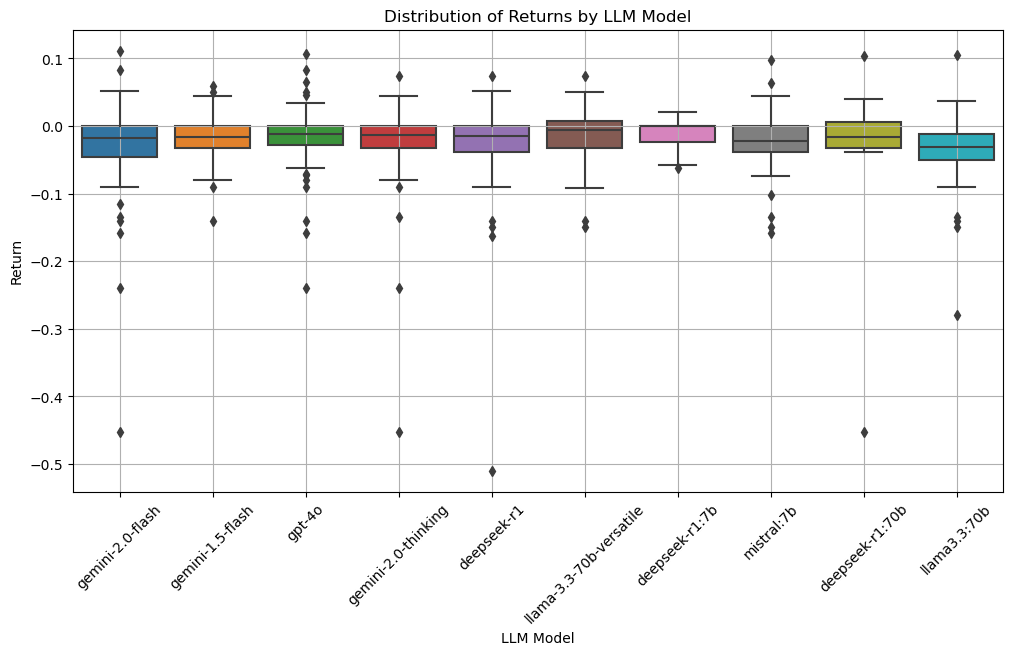

In [4]:
# Box plot of return by model to compare performance distribution
plt.figure(figsize=(12, 6))
sns.boxplot(x=df["model"], y=df["return"])
plt.xticks(rotation=45)
plt.xlabel("LLM Model")
plt.ylabel("Return")
plt.title("Distribution of Returns by LLM Model")
plt.grid(True)
plt.show()

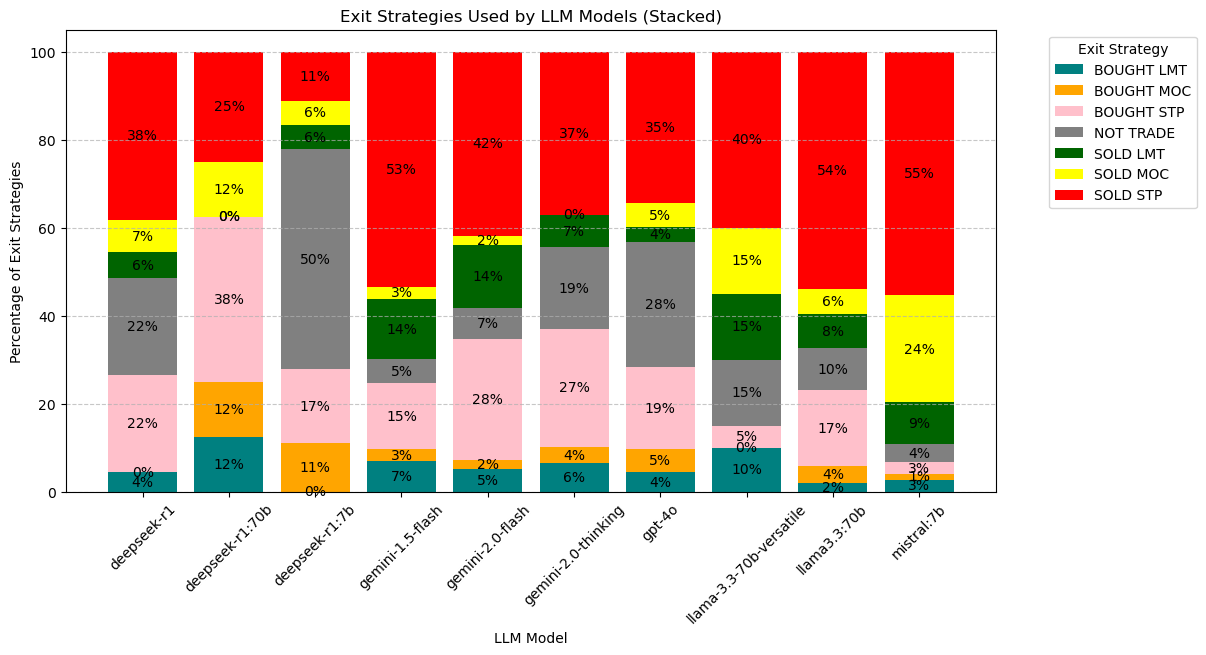

In [22]:
# Ensure no duplicate column names
df = df.loc[:, ~df.columns.duplicated()]

# Replace empty exit strategies with "NOT TRADE" where llm_action == "NEITHER"
df.loc[df["llm_action"] == "NEITHER", "exit"] = "NOT TRADE"

# Compute count and normalize to percentages
df_counts = df.groupby(["model", "exit"]).size().reset_index(name="count")
df_counts["percentage"] = df_counts.groupby("model")["count"].transform(lambda x: (x / x.sum()) * 100)  # Convert to percentage

# Pivot the data to get a stacked format for plotting
df_pivot = df_counts.pivot(index="model", columns="exit", values="percentage").fillna(0)

# Define custom colors for exit strategies
custom_colors = {
    "NOT TRADE": "gray",
    "SOLD LMT": "darkgreen",
    "BOUGHT LMT": "teal",
    "SOLD STP": "red",
    "BOUGHT STP": "pink",
    "SOLD MOC": "yellow",
    "BOUGHT MOC": "orange",
}

# Plot stacked bar chart with custom colors
fig, ax = plt.subplots(figsize=(12, 6))

# Plot each exit strategy in the specified color
bottom_values = None
for exit_strategy in df_pivot.columns:
    color = custom_colors.get(exit_strategy, "black")  # Default to black if missing
    if bottom_values is None:
        bottom_values = df_pivot[exit_strategy].values
        ax.bar(df_pivot.index, df_pivot[exit_strategy], label=exit_strategy, color=color)
    else:
        ax.bar(df_pivot.index, df_pivot[exit_strategy], bottom=bottom_values, label=exit_strategy, color=color)
        bottom_values += df_pivot[exit_strategy].values

# Formatting
plt.xticks(rotation=45)
plt.xlabel("LLM Model")
plt.ylabel("Percentage of Exit Strategies")
plt.title("Exit Strategies Used by LLM Models (Stacked)")
plt.legend(title="Exit Strategy", bbox_to_anchor=(1.05, 1), loc='upper left')

# Show percentage labels on bars
for container in ax.containers:
    ax.bar_label(container, fmt="%.0f%%", label_type="center", fontsize=10, color="black")

plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

## Plotly Interactive plots

In [ ]:
# Ensure necessary columns exist
if "model" in df.columns and "profitible_action" in df.columns and "llm_action" in df.columns:
    unique_models = df["model"].unique()
    action_labels = ["BUY", "SELL", "NEITHER"]  # Standardized action labels

    # Create a subplot grid with one 3x3 confusion matrix per model
    num_models = len(unique_models)
    cols = 3  # Define columns per row
    rows = -(-num_models // cols)  # Compute required rows
    
    fig = sp.make_subplots(rows=rows, cols=cols, subplot_titles=unique_models)

    for idx, model in enumerate(unique_models):
        model_df = df[df["model"] == model]

        # Generate confusion matrix for this model
        conf_matrix = np.zeros((3, 3), dtype=int)

        for _, row in model_df.iterrows():
            if row["profitible_action"] in action_labels and row["llm_action"] in action_labels:
                i = action_labels.index(row["profitible_action"])
                j = action_labels.index(row["llm_action"])
                conf_matrix[i, j] += 1

        # Reorder matrix rows to conform to BUY, SELL, NEITHER standard
        conf_matrix = conf_matrix[[0, 1, 2], :]  # Ensure the correct row order

        # Determine subplot position
        row_idx = idx // cols + 1
        col_idx = idx % cols + 1

        # Add heatmap for each model
        heatmap = go.Heatmap(
            z=conf_matrix[::-1],  # Flip the data to match row order
            x=action_labels,
            y=action_labels[::-1],  # Flip the row labels to match the new order
            colorscale="Blues",
            showscale=False
        )
        
        fig.add_trace(heatmap, row=row_idx, col=col_idx)

        # Add annotations
        for i in range(3):
            for j in range(3):
                fig.add_annotation(
                    text=str(conf_matrix[::-1][i, j]),
                    x=action_labels[j],
                    y=action_labels[::-1][i],  # Match annotation to flipped data
                    showarrow=False,
                    font=dict(color="black"),
                    row=row_idx,
                    col=col_idx
                )

    # Adjust layout
    fig.update_layout(
        title="Confusion Matrices for Each LLM Model",
        height=300 * rows,  # Adjust height dynamically
        width=900,  # Fixed width
        margin=dict(l=50, r=50, t=50, b=50)
    )

    fig.show()
else:
    print("The necessary columns ('model', 'profitible_action', 'llm_action') are missing from the dataset.")

In [16]:
df["return_percent"] = df["return"] * 100  # Convert decimal to percentage

# Create scatter plot
fig = px.scatter(
    df, 
    x="position", 
    y="return_percent", 
    color="model", 
    hover_data=["position", "return_percent"], 
    labels={"position": "Position ($)", "return_percent": "Return (%)"}, 
    title="Scatter Plot of Position vs. Return"
)

# Format axes
fig.update_layout(
    xaxis=dict(tickprefix="$", title="Position ($)"),
    yaxis=dict(ticksuffix="%", title="Return (%)"),
    legend_title="Model"
)

# Show plot
fig.show()

In [26]:
# Box plot of return by model to compare performance distribution
fig3 = px.box(df, x="model", y="return", title="Distribution of Returns by LLM Model",
              labels={"model": "LLM Model", "return": "Return"})
fig3.show()

In [23]:
# Ensure no duplicate column names
df = df.loc[:, ~df.columns.duplicated()]

# Replace empty exit strategies with "NOT TRADE" where llm_action == "NEITHER"
df.loc[df["llm_action"] == "NEITHER", "exit"] = "NOT TRADE"

# Compute count and normalize to percentages
df_counts = df.groupby(["model", "exit"]).size().reset_index(name="count")
df_counts["percentage"] = df_counts.groupby("model")["count"].transform(lambda x: (x / x.sum()) * 100)  # Convert to percentage

# Convert data to long format for Plotly
df_long = df_counts.copy()
df_long["percentage"] = df_long["percentage"].round(2)  # Round percentages for better display

# Define custom colors for exit strategies
custom_colors = {
    "NOT TRADE": "gray",
    "SOLD LMT": "darkgreen",
    "BOUGHT LMT": "teal",
    "SOLD STP": "red",
    "BOUGHT STP": "pink",
    "SOLD MOC": "yellow",
    "BOUGHT MOC": "orange",
}

# Create stacked bar chart using Plotly
fig = px.bar(
    df_long,
    x="model",
    y="percentage",
    color="exit",
    text="percentage",
    title="Exit Strategies Used by LLM Models (Stacked)",
    labels={"percentage": "Percentage of Exit Strategies", "model": "LLM Model"},
    color_discrete_map=custom_colors,
)

# Update layout for better visualization
fig.update_layout(
    barmode="stack",
    xaxis_tickangle=-45,
    yaxis_title="Percentage of Exit Strategies",
    legend_title="Exit Strategy",
    plot_bgcolor="white",
)

# Show percentage labels on bars
fig.update_traces(texttemplate="%{text}%", textposition="inside")

# Display the Plotly chart
fig.show()